In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
import seaborn as sn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [ ]:
root = '/content/drive/MyDrive/train_test'

train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Cat', 'Dog']
Training images available: 88
Testing images available:  20


In [ ]:
VGG19model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.7MB/s]


In [ ]:
for param in VGG19model.parameters():
    param.requires_grad = False

Label: [0 0 1 1 0 0 1 1 0 1]
Class: Cat Cat Dog Dog Cat Cat Dog Dog Cat Dog


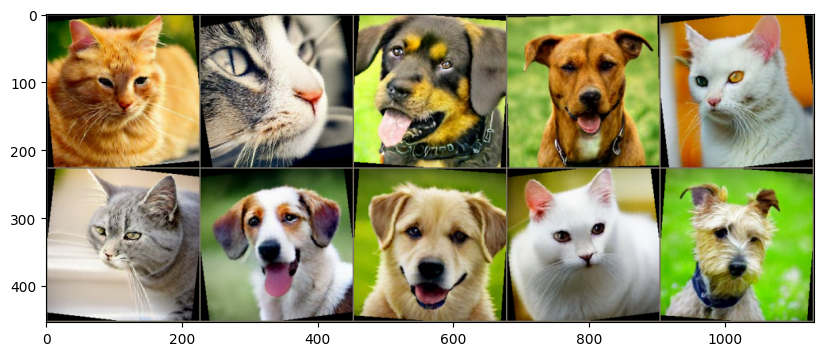

In [ ]:
# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [ ]:
# Modify the classifier

torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)
)


In [ ]:
for param in VGG19model.parameters():
    print(param.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
2048
2


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG19model.classifier.parameters(), lr=0.001)

In [ ]:
# Set time tracking
import time
start_time = time.time()

epochs = 3
max_trn_batch = 88  # As per your dataset size
max_tst_batch = 20  # As per your test dataset size

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # X_train, y_train = X_train.to(device), y_train.to(device)

        # Apply the model
        y_pred = VGG19model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Print interim results
        if b%20==0:
          acc = trn_corr.item()*100 / ((b+1)*train_loader.batch_size)
          print(f'epoch: {i+1}  batch: {b+1} loss: {loss.item():.4f} accuracy: {acc:.2f}%')


    train_losses.append(loss)
    train_correct.append(trn_corr)

    # X_test, y_test = X_test.to(device), y_test.to(device)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = VGG19model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


Duration: 234 seconds


In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(20), tensor(20), tensor(20)]
Test accuracy: 100.000%


In [ ]:
# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

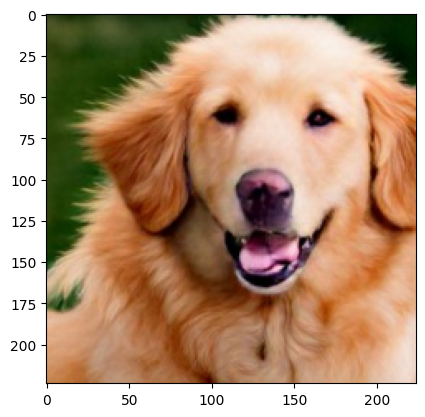

In [ ]:
image_index = 16
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.show()



In [ ]:
# VGG19 Model Prediction:

VGG19model.eval()
with torch.no_grad():
    new_pred = VGG19model(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_pred.item()]

'Dog'

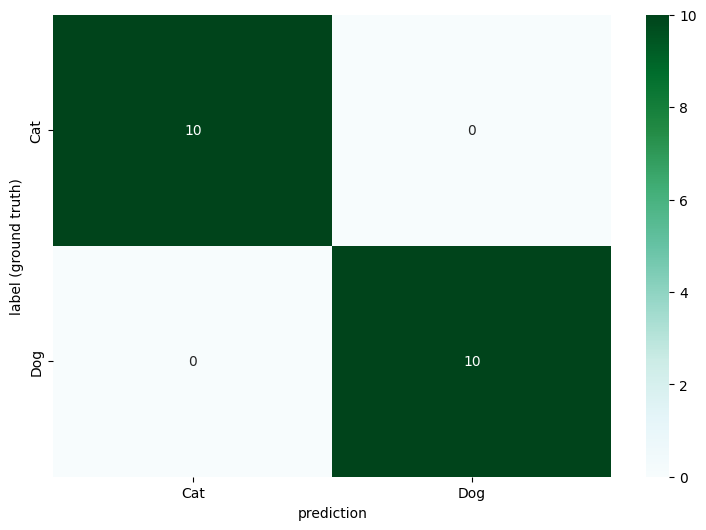

In [ ]:

test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = VGG19model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)

plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [ ]:
torch.save(VGG19model.state_dict(), 'vignesh3.pt')

